In [1]:
%matplotlib inline
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from sympy import *
from ztfquery import lightcurve, query, metasearch
import scipy.stats as st
from scipy.stats import ks_2samp

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


### Defining Functions

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
   
    """Function converts from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    alert_mag : float
        Difference magnitude of alert.
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
        

    Returns
    -------
    app_mag
        Apparent magnitude as type ``float``.
    
    """
    if sign =='t': 
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag)),10))
    else:
        app_mag = ((-2.5)*log((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)),10)) 
    
    return float(app_mag)

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err):
    
    """Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    
    Parameters
    ----------
    ref_mag : float
        Magnitude of reference source.
    
    alert_mag : float
        Difference magnitude of alert.
    
    sign : str
        Sign of the difference magnitude where
        t = positive difference magnitude = brightening
        f = negative difference magnitude = faintening.
    
    ref_err : float
        1-sigma uncertainty in reference magnitude.
   
    alert_err : float
        1-sigma uncertainty in alert magnitude.
        

    Returns
    -------
    app_err
        Apparent magnitude error as type ``float``.
    
    """
    
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log((10**((-.4)*r)) + (10**((-.4)*a)),10))
    else:
        f = ((-2.5)*log((10**((-.4)*r)) - (10**((-.4)*a)),10)) 
    
    
    # f = diff_to_app_mag(ref_mag, alert_mag, sign)
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Query for Disappearing Stars

In [4]:
jdnow = str(Time.now().jd)

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand > 5)
AND (objects.ncand < 20)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ((objects.mag_r28 < objects.mag_r08 < objects.mag_r02)
   OR (objects.mag_g28 < objects.mag_g08 < objects.mag_g02))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < 5

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)
    
print('Query returned ' + str(len(v4)) + ' candidates')

Query returned 41 candidates


### Plotting Light Curves from Alert Packet and ZTF archive 

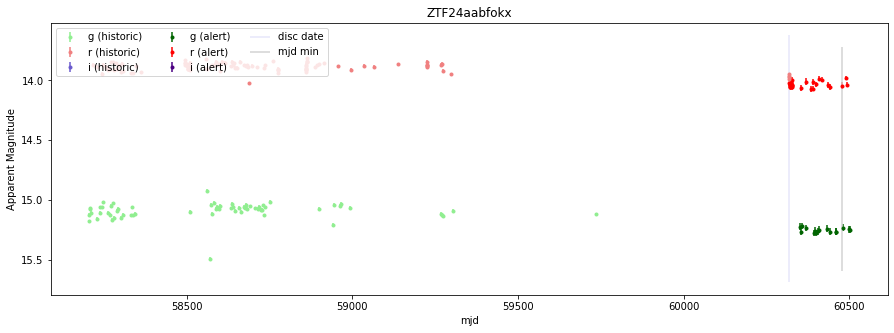

ZTF24aabfokx g-band KS result: KstestResult(statistic=0.9846153846153847, pvalue=1.2212453270876722e-15)
ZTF24aabfokx r-band KS result: KstestResult(statistic=0.9805825242718447, pvalue=8.500876908822559e-40)

ZTF24aabfokx g-band Chi Square statistic: 21.305635379746153
ZTF24aabfokx r-band Chi Square statistic: 7.53529733827035



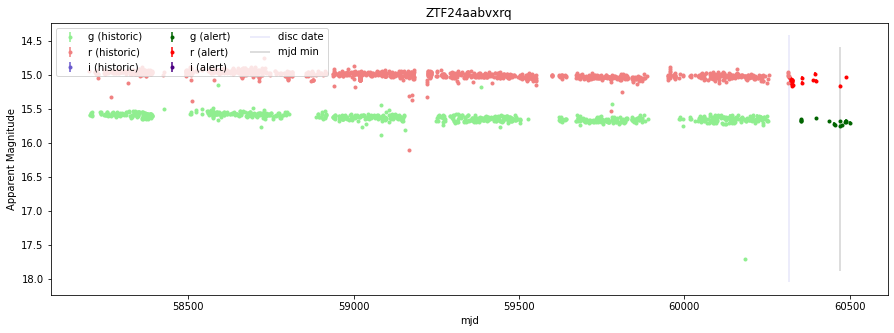

ZTF24aabvxrq g-band KS result: KstestResult(statistic=0.6748587570621469, pvalue=3.7043734912867166e-07)
ZTF24aabvxrq r-band KS result: KstestResult(statistic=0.8056538591169532, pvalue=4.440892098500626e-16)

ZTF24aabvxrq g-band Chi Square statistic: 21.553817310880195
ZTF24aabvxrq r-band Chi Square statistic: 19.874404438400674



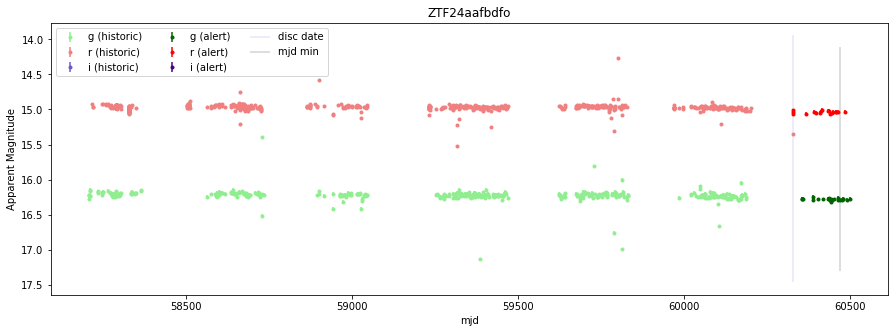

ZTF24aafbdfo g-band KS result: KstestResult(statistic=0.8604651162790697, pvalue=3.153391366861751e-19)
ZTF24aafbdfo r-band KS result: KstestResult(statistic=0.9439050701186623, pvalue=6.048601411728245e-23)

ZTF24aafbdfo g-band Chi Square statistic: 15.912922150694829
ZTF24aafbdfo r-band Chi Square statistic: 12.764598771545135



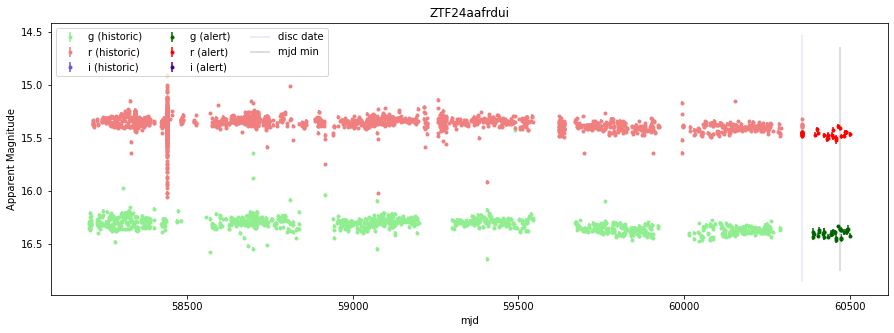

ZTF24aafrdui g-band KS result: KstestResult(statistic=0.7488778054862842, pvalue=2.524010256416037e-17)
ZTF24aafrdui r-band KS result: KstestResult(statistic=0.8456496960486323, pvalue=2.5000099806074282e-26)

ZTF24aafrdui g-band Chi Square statistic: 19.81848106233871
ZTF24aafrdui r-band Chi Square statistic: 34.31167080640471



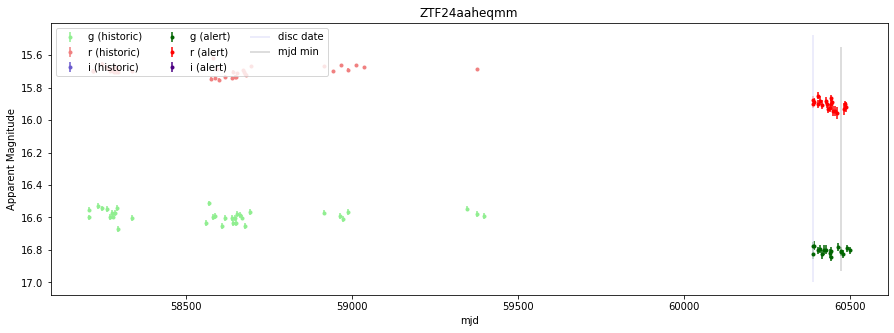

ZTF24aaheqmm g-band KS result: KstestResult(statistic=1.0, pvalue=1.3511414209688155e-13)
ZTF24aaheqmm r-band KS result: KstestResult(statistic=1.0, pvalue=1.4432899320127035e-15)

ZTF24aaheqmm g-band Chi Square statistic: 4.183219593929047
ZTF24aaheqmm r-band Chi Square statistic: 7.432130827757789



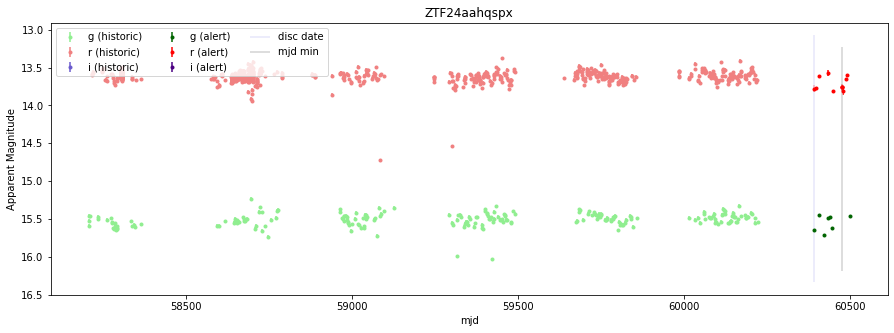

ZTF24aahqspx g-band KS result: KstestResult(statistic=0.3707936507936508, pvalue=0.24140994630978108)
ZTF24aahqspx r-band KS result: KstestResult(statistic=0.6229408175716901, pvalue=0.00012892716546242244)

ZTF24aahqspx g-band Chi Square statistic: 17.838459486389073
ZTF24aahqspx r-band Chi Square statistic: 12.06348681997326



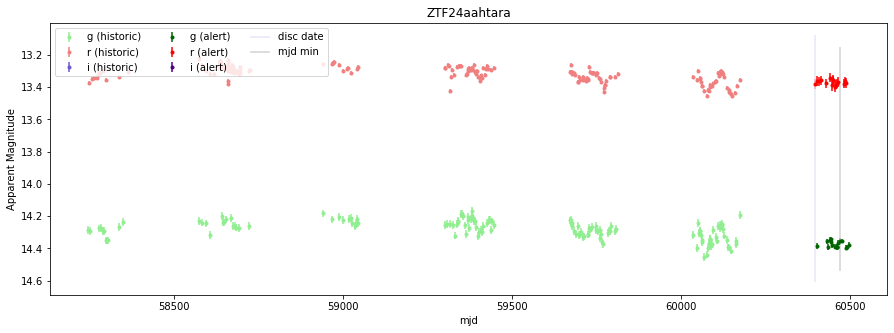

ZTF24aahtara g-band KS result: KstestResult(statistic=0.8394160583941606, pvalue=6.802891583390647e-12)
ZTF24aahtara r-band KS result: KstestResult(statistic=0.8810572687224669, pvalue=2.4313884239290928e-14)

ZTF24aahtara g-band Chi Square statistic: 5.6609326322910345
ZTF24aahtara r-band Chi Square statistic: 11.466220199593641



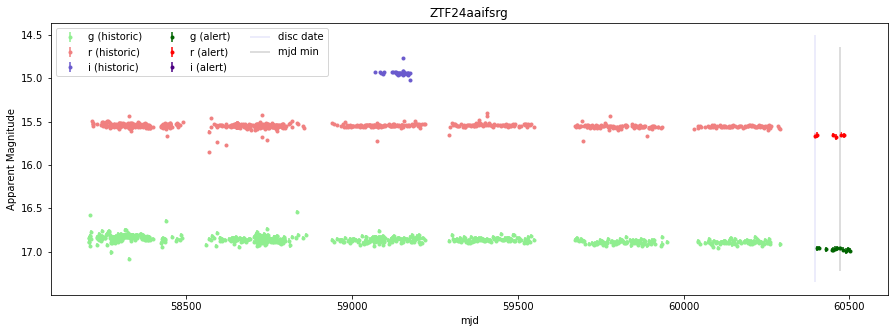

ZTF24aaifsrg g-band KS result: KstestResult(statistic=0.9975216852540273, pvalue=3.3306690738754696e-16)
ZTF24aaifsrg r-band KS result: KstestResult(statistic=0.9901960784313726, pvalue=1.0031531161303064e-11)

ZTF24aaifsrg g-band Chi Square statistic: 2.6780295988735094
ZTF24aaifsrg r-band Chi Square statistic: 4.417383303623381



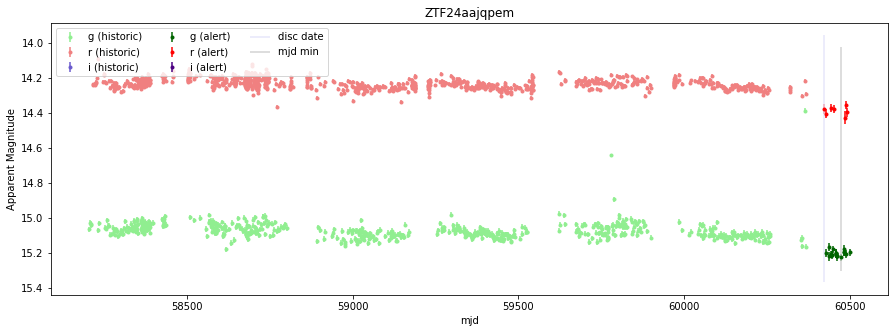

ZTF24aajqpem g-band KS result: KstestResult(statistic=0.9982078853046595, pvalue=7.771561172376096e-16)
ZTF24aajqpem r-band KS result: KstestResult(statistic=0.9990740740740741, pvalue=0.0)

ZTF24aajqpem g-band Chi Square statistic: 13.682192418492434
ZTF24aajqpem r-band Chi Square statistic: 7.1521410533200935



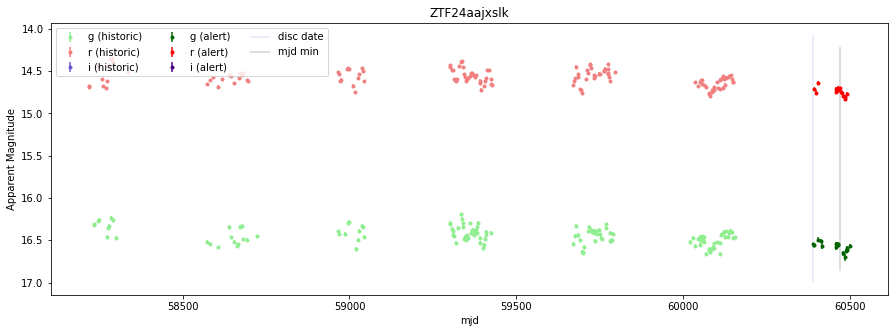

ZTF24aajxslk g-band KS result: KstestResult(statistic=0.7194444444444444, pvalue=6.754887260651543e-08)
ZTF24aajxslk r-band KS result: KstestResult(statistic=0.8271221532091098, pvalue=7.751873587480418e-10)

ZTF24aajxslk g-band Chi Square statistic: 23.333562966602294
ZTF24aajxslk r-band Chi Square statistic: 45.264238851750875



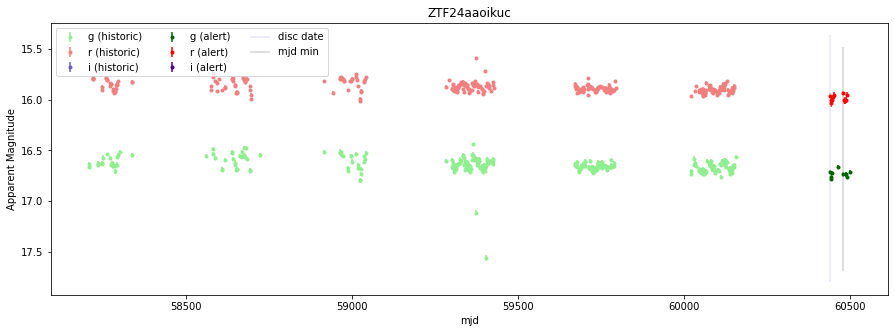

ZTF24aaoikuc g-band KS result: KstestResult(statistic=0.8252846486062034, pvalue=5.866517893693413e-07)
ZTF24aaoikuc r-band KS result: KstestResult(statistic=0.9432624113475178, pvalue=9.213740881364174e-13)

ZTF24aaoikuc g-band Chi Square statistic: 13.215317989525673
ZTF24aaoikuc r-band Chi Square statistic: 16.507068611824756



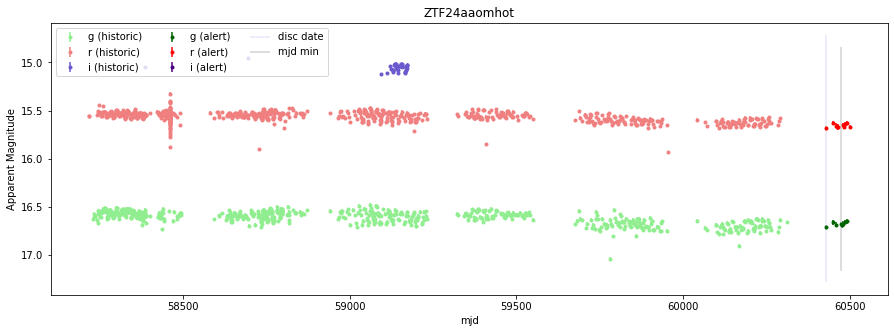

ZTF24aaomhot g-band KS result: KstestResult(statistic=0.7655367231638418, pvalue=2.447144156603187e-05)
ZTF24aaomhot r-band KS result: KstestResult(statistic=0.9303391384051329, pvalue=1.0229372904291267e-11)

ZTF24aaomhot g-band Chi Square statistic: 13.37844580595078
ZTF24aaomhot r-band Chi Square statistic: 14.117856904278089



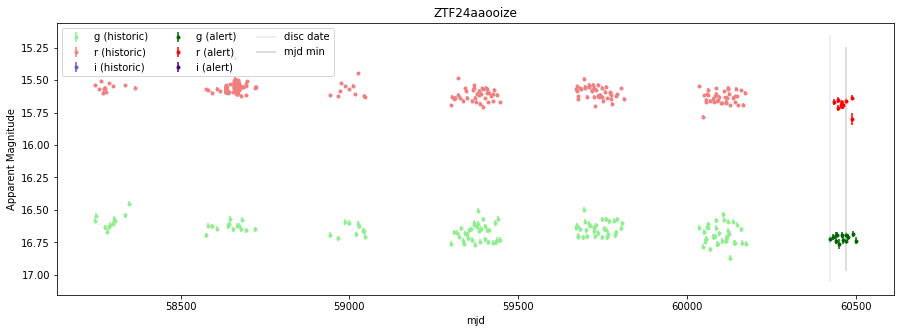

ZTF24aaooize g-band KS result: KstestResult(statistic=0.6470588235294118, pvalue=2.601967740922806e-05)
ZTF24aaooize r-band KS result: KstestResult(statistic=0.9161147902869757, pvalue=1.1564060820035138e-10)

ZTF24aaooize g-band Chi Square statistic: 11.085716045460495
ZTF24aaooize r-band Chi Square statistic: 11.764476951337128



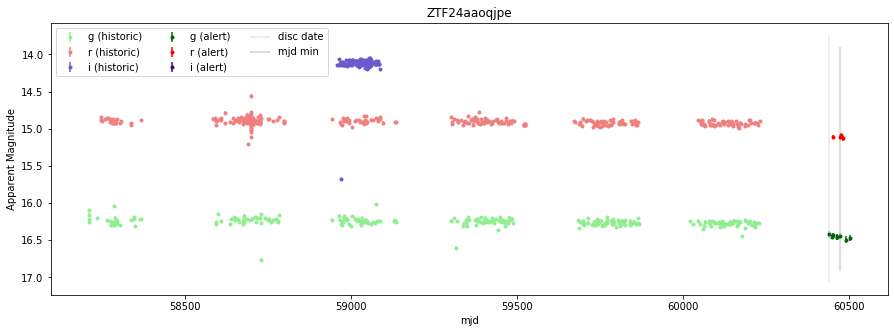

ZTF24aaoqjpe g-band KS result: KstestResult(statistic=0.9882352941176471, pvalue=6.471490010540037e-13)
ZTF24aaoqjpe r-band KS result: KstestResult(statistic=0.9953703703703703, pvalue=2.020129097335399e-08)

ZTF24aaoqjpe g-band Chi Square statistic: 11.297497169354841
ZTF24aaoqjpe r-band Chi Square statistic: 8.509551626141608



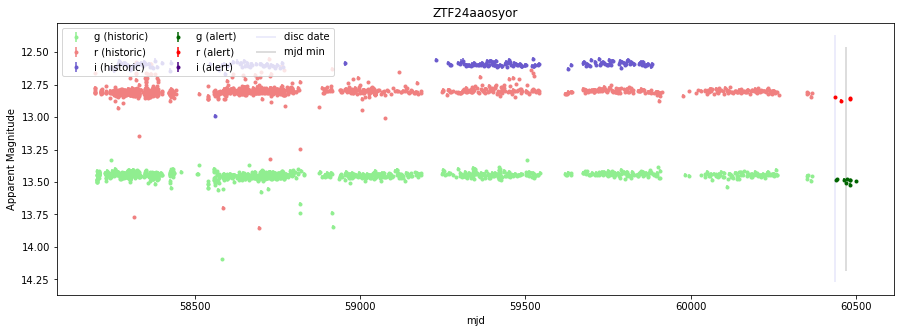

ZTF24aaosyor g-band KS result: KstestResult(statistic=0.9474452554744526, pvalue=1.0777378989246245e-11)
ZTF24aaosyor r-band KS result: KstestResult(statistic=0.9772413793103448, pvalue=7.122248660840214e-07)

ZTF24aaosyor g-band Chi Square statistic: 6.015888670858932
ZTF24aaosyor r-band Chi Square statistic: 28.197840359625268



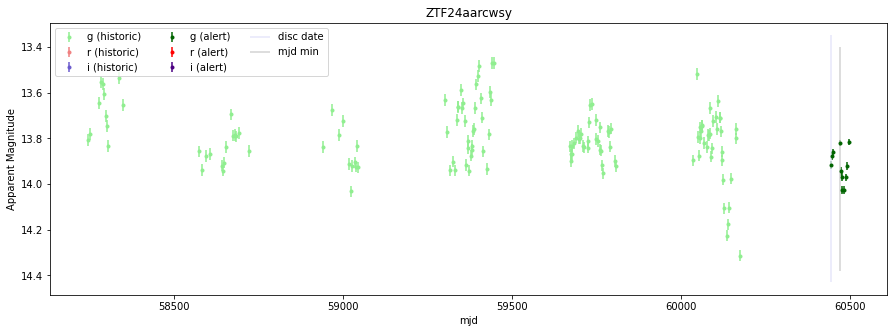

ZTF24aarcwsy g-band KS result: KstestResult(statistic=0.5620437956204379, pvalue=0.001545724737760823)

ZTF24aarcwsy g-band Chi Square statistic: 30.116360563687742



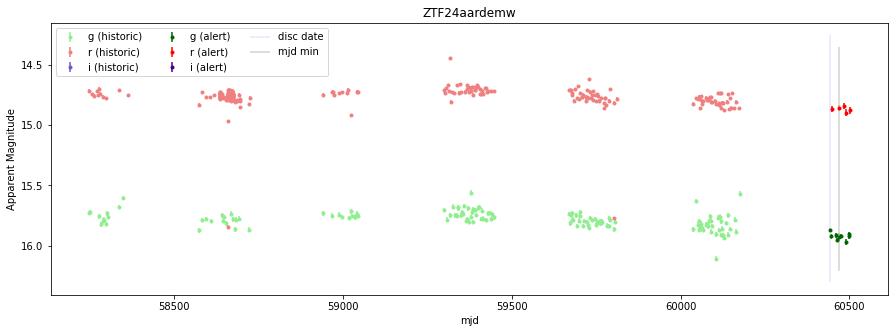

ZTF24aardemw g-band KS result: KstestResult(statistic=0.9343065693430657, pvalue=1.5054253399426898e-09)
ZTF24aardemw r-band KS result: KstestResult(statistic=0.9714912280701754, pvalue=1.0093402191824197e-07)

ZTF24aardemw g-band Chi Square statistic: 13.09480914916605
ZTF24aardemw r-band Chi Square statistic: 45.198286576223026



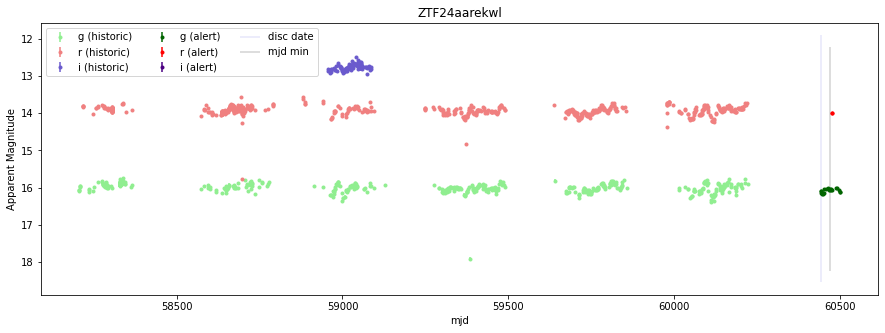

ZTF24aarekwl g-band KS result: KstestResult(statistic=0.6320754716981132, pvalue=1.1002747712929306e-08)
ZTF24aarekwl r-band KS result: KstestResult(statistic=0.8490990990990991, pvalue=0.04612022570860108)

ZTF24aarekwl g-band Chi Square statistic: 18.07395399668354
ZTF24aarekwl r-band Chi Square statistic: 19.036193596911012



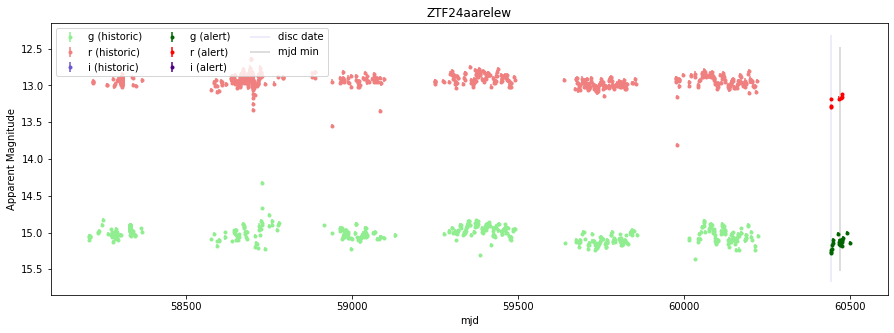

ZTF24aarelew g-band KS result: KstestResult(statistic=0.6823308270676691, pvalue=8.365805825860662e-10)
ZTF24aarelew r-band KS result: KstestResult(statistic=0.9930769230769231, pvalue=1.7430501486614958e-14)

ZTF24aarelew g-band Chi Square statistic: 15.941774124968015
ZTF24aarelew r-band Chi Square statistic: 5.524648773599769



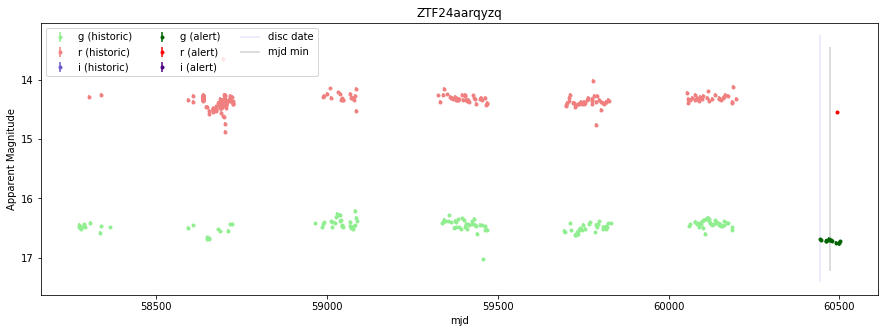

ZTF24aarqyzq g-band KS result: KstestResult(statistic=0.9806451612903225, pvalue=6.661338147750939e-16)
ZTF24aarqyzq r-band KS result: KstestResult(statistic=0.9832935560859188, pvalue=0.03809523809523807)

ZTF24aarqyzq g-band Chi Square statistic: 13.369938097283548
ZTF24aarqyzq r-band Chi Square statistic: 7.51635912318578



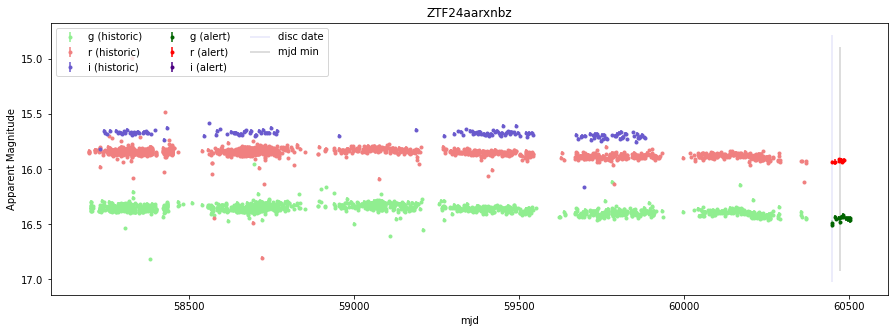

ZTF24aarxnbz g-band KS result: KstestResult(statistic=0.9433638443935927, pvalue=1.6653345369377348e-15)
ZTF24aarxnbz r-band KS result: KstestResult(statistic=0.9749518304431599, pvalue=5.192513086171857e-13)

ZTF24aarxnbz g-band Chi Square statistic: 8.091079962039629
ZTF24aarxnbz r-band Chi Square statistic: 12.391566830700189



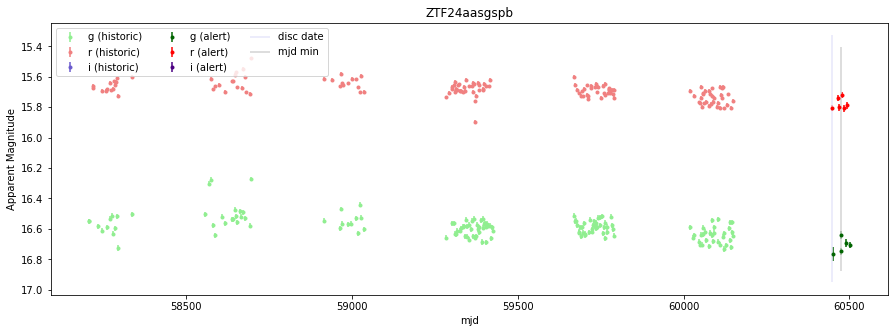

ZTF24aasgspb g-band KS result: KstestResult(statistic=0.7866666666666666, pvalue=0.001253114221487217)
ZTF24aasgspb r-band KS result: KstestResult(statistic=0.7692307692307693, pvalue=0.0005075136426327953)

ZTF24aasgspb g-band Chi Square statistic: 19.712134389224083
ZTF24aasgspb r-band Chi Square statistic: 26.5761743975863



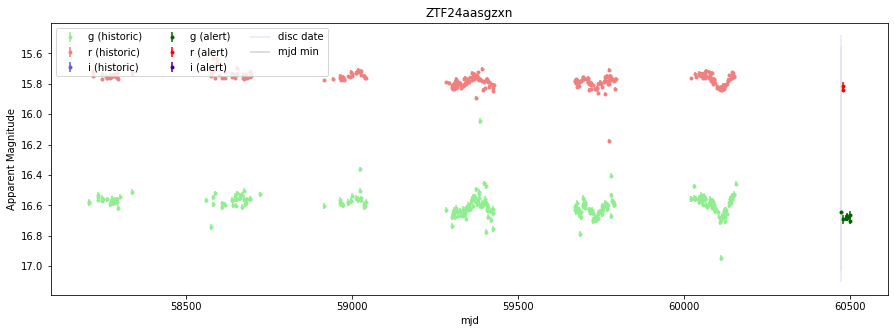

ZTF24aasgzxn g-band KS result: KstestResult(statistic=0.8098591549295775, pvalue=5.868477604087374e-06)
ZTF24aasgzxn r-band KS result: KstestResult(statistic=0.8475177304964538, pvalue=0.04927089035982679)

ZTF24aasgzxn g-band Chi Square statistic: 14.110551304026334
ZTF24aasgzxn r-band Chi Square statistic: 13.161643447273718



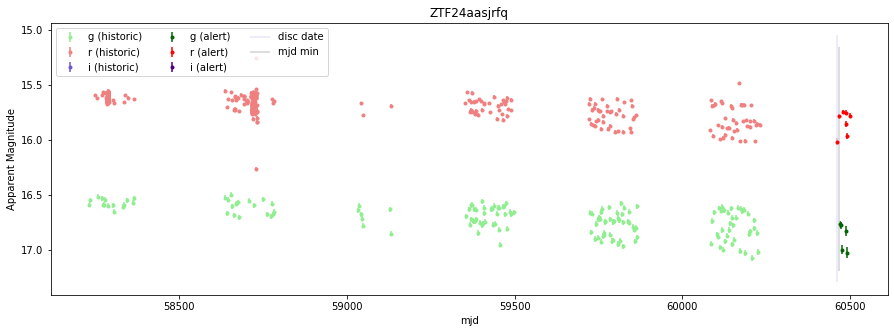

ZTF24aasjrfq g-band KS result: KstestResult(statistic=0.7006369426751592, pvalue=0.0069257606043307)
ZTF24aasjrfq r-band KS result: KstestResult(statistic=0.8655616942909761, pvalue=2.185485924566244e-06)

ZTF24aasjrfq g-band Chi Square statistic: 29.300192239082172
ZTF24aasjrfq r-band Chi Square statistic: 46.46138456361619



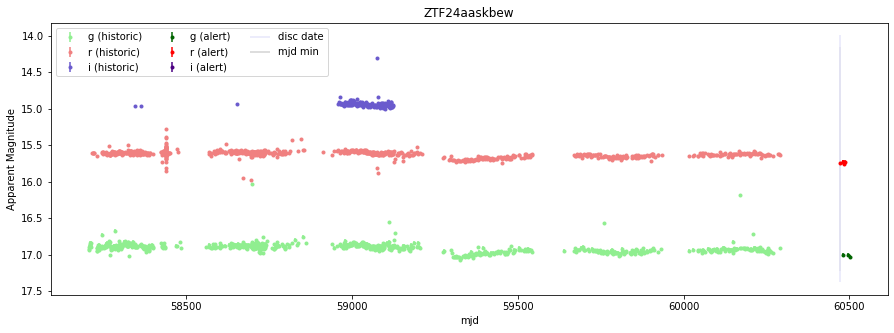

ZTF24aaskbew g-band KS result: KstestResult(statistic=0.9647201946472019, pvalue=0.00010638537458484976)
ZTF24aaskbew r-band KS result: KstestResult(statistic=0.9916743755781684, pvalue=3.210189891689197e-10)

ZTF24aaskbew g-band Chi Square statistic: 13.182150032518475
ZTF24aaskbew r-band Chi Square statistic: 11.147023471178922



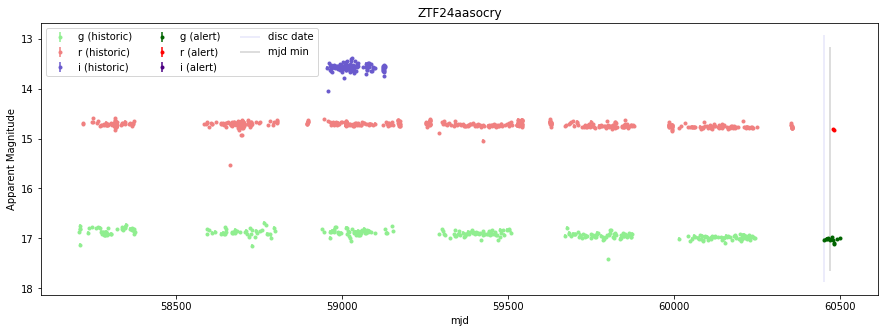

ZTF24aasocry g-band KS result: KstestResult(statistic=0.8235294117647058, pvalue=5.651494161540427e-09)
ZTF24aasocry r-band KS result: KstestResult(statistic=0.9920774647887324, pvalue=0.00017002780727504163)

ZTF24aasocry g-band Chi Square statistic: 6.951046104013701
ZTF24aasocry r-band Chi Square statistic: 3.5910616210610256



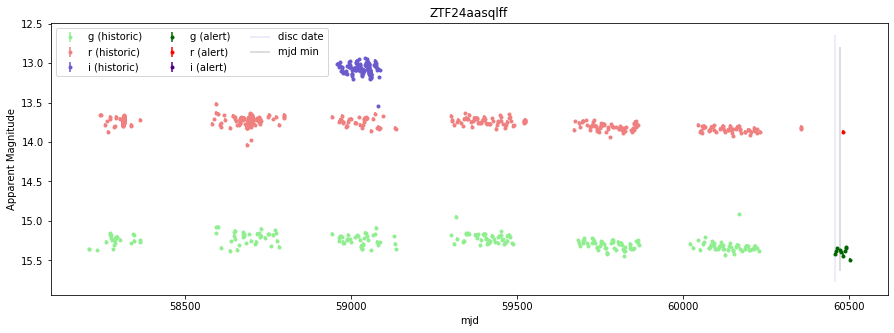

ZTF24aasqlff g-band KS result: KstestResult(statistic=0.782608695652174, pvalue=1.1517550264628085e-06)
ZTF24aasqlff r-band KS result: KstestResult(statistic=0.9819277108433735, pvalue=0.038507821901323736)

ZTF24aasqlff g-band Chi Square statistic: 20.022155517563373
ZTF24aasqlff r-band Chi Square statistic: 5.680930419813261



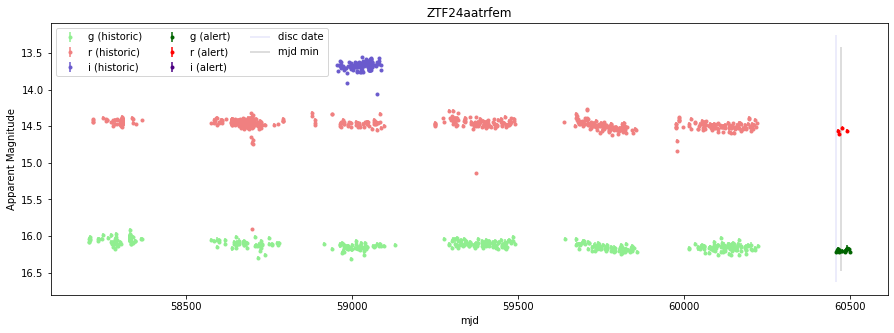

ZTF24aatrfem g-band KS result: KstestResult(statistic=0.7830137726167972, pvalue=2.597303261353545e-09)
ZTF24aatrfem r-band KS result: KstestResult(statistic=0.932483120780195, pvalue=4.6014537032235125e-05)

ZTF24aatrfem g-band Chi Square statistic: 5.34846268861121
ZTF24aatrfem r-band Chi Square statistic: 7.9017857732921435



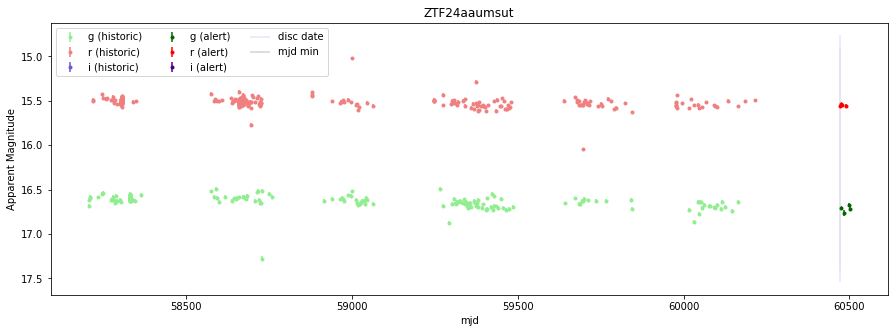

ZTF24aaumsut g-band KS result: KstestResult(statistic=0.8671875, pvalue=0.0007935237326244238)
ZTF24aaumsut r-band KS result: KstestResult(statistic=0.8691460055096418, pvalue=0.000641531601943135)

ZTF24aaumsut g-band Chi Square statistic: 9.385522682671066
ZTF24aaumsut r-band Chi Square statistic: 7.8983217836809345



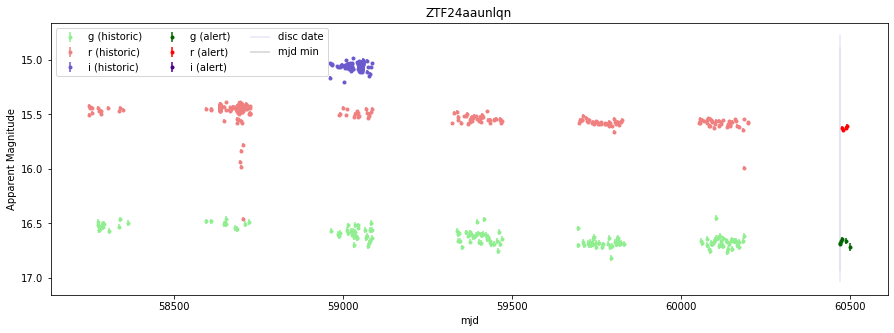

ZTF24aaunlqn g-band KS result: KstestResult(statistic=0.5225806451612903, pvalue=0.055790717521937205)
ZTF24aaunlqn r-band KS result: KstestResult(statistic=0.9761388286334056, pvalue=1.4196457569504162e-06)

ZTF24aaunlqn g-band Chi Square statistic: 8.927628663040288
ZTF24aaunlqn r-band Chi Square statistic: 31.272556409157975



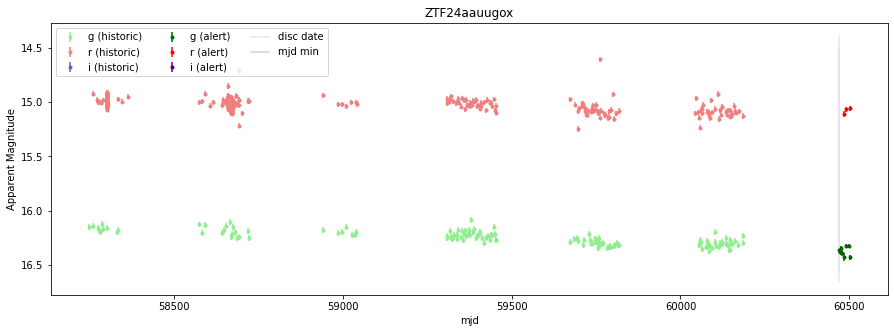

ZTF24aauugox g-band KS result: KstestResult(statistic=0.8854961832061069, pvalue=3.48343179745747e-07)
ZTF24aauugox r-band KS result: KstestResult(statistic=0.8539130434782609, pvalue=0.00662125768851729)

ZTF24aauugox g-band Chi Square statistic: 5.285841950687804
ZTF24aauugox r-band Chi Square statistic: 4.99692881135376

31 candidates remain
10 stars in trash


In [5]:
Dips= L.objects([row['objectId'] for row in v4])
lc = {}
candidates = []
trash = []

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')
    
    # Pulling historic ZTF light curve
    ztf = lightcurve.LCQuery.from_position(obj['objectData']['ramean'], obj['objectData']['decmean'], 1)
    
    # Defining arrays of ZTF historic magnitudes for each filter
    ztf_gsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rsamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_isamp = np.array(ztf.data['mag'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # same for magnitude errors
    ztf_gerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rerr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_ierr = np.array(ztf.data['magerr'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # ...and dates
    ztf_gmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zg'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_rmjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zr'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    ztf_imjd = np.array(ztf.data['mjd'][ztf.data['filtercode'] == 'zi'][ztf.data['mjd'] < obj['objectData']['discMjd']])
    
    # Creating empty lists for each ZTF filter-band to be filled with apparent magnitudes and errors
    gmag = []
    rmag = []
    imag = []
    
    gerr = []
    rerr = []
    ierr = []
    
    gmjd = []
    rmjd = []
    imjd = []
    
    for i in lc[obj['objectId']]['candidates']:
        if 'isdiffpos' in i:
            app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos']) # calculating apparent magnitude 
            app_err = app_mag_err_prop(i['magnr'], i['magpsf'], i['isdiffpos'], i['sigmagnr'], i['sigmapsf']) # propagating error
            
            # appending magnitudes and errors in each filter to their respective lists
            if i['fid']== 1:
                gmag.append(app_mag)
                gerr.append(app_err)
                gmjd.append(i['mjd'])
            if i['fid']== 2:
                rmag.append(app_mag)
                rerr.append(app_err)
                rmjd.append(i['mjd'])
            if i['fid']== 3:
                imag.append(app_mag)
                ierr.append(app_err)
                imjd.append(i['mjd'])
    
    
    # Converting lists of alert packet magnitudes to arrays 
    alert_gsamp = np.array(gmag)
    alert_rsamp = np.array(rmag)
    alert_isamp = np.array(imag)
    
    # Performing K-S test with 95% confidence intervals for each filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
        KS_g = st.ks_2samp(alert_gsamp, ztf_gsamp)
        #D_crit_g = 1.36*((1/len(alert_gsamp))+(1/len(ztf_gsamp)))
            
    if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
        KS_r = st.ks_2samp(alert_rsamp, ztf_rsamp)
        #D_crit_r = 1.36*((1/len(alert_rsamp))+(1/len(ztf_rsamp)))

    if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
        KS_i = st.ks_2samp(alert_isamp, ztf_isamp)
        #D_crit_i = 1.36*((1/len(alert_isamp))+(1/len(ztf_isamp)))
   
    
    # Calculating Chi Square statistics for each filter
    if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
        chisq_g = np.sum((((ztf_gsamp - np.median(ztf_gsamp)) / ztf_gerr)**2 ) / float(len(ztf_gsamp)))
        #df_g = len(ztf_gsamp) - 1
        #crit_g = st.chi2.ppf(0.95, df_g)
        
    if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
        chisq_r = np.sum((((ztf_rsamp - np.median(ztf_rsamp)) / ztf_rerr)**2 ) / float(len(ztf_rsamp)))
        #df_r = len(ztf_rsamp) - 1
        #crit_r = st.chi2.ppf(0.95, df_r)
        
    if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
        chisq_i = np.sum((((ztf_isamp - np.median(ztf_isamp)) / ztf_ierr)**2 ) / float(len(ztf_isamp)))
        #df_i = len(ztf_isamp) - 1
        #crit_i = st.chi2.ppf(0.95, df_i)
    
    # Imposing conditions that K-S test p-value is < 0.05 (95% confidence interval) and Chi square statistic is < 50
    if (('KS_g.pvalue' not in globals() or KS_g.pvalue < 0.05) and 
        ('KS_r.pvalue' not in globals() or KS_r.pvalue < 0.05) and 
        ('KS_i.pvalue' not in globals() or KS_i.pvalue < 0.05) and 
        ('chisq_g' not in globals() or chisq_g < 50) and 
        ('chisq_r' not in globals() or chisq_r < 50) and 
        ('chisq_i' not in globals() or chisq_i < 50)):
        
        candidates.append(obj['objectId'])
        
        # Plotting
        plt.figure(figsize = (15, 5))
        plt.subplot(111)

        ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
        ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
        ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

        gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
        rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
        ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

        mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
        disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
        plt.gca().invert_yaxis()
        plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
        plt.ylabel('Apparent Magnitude')
        plt.xlabel('mjd')
        plt.title(obj['objectId'])
        plt.show()

        # Printing K-S test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band KS result: '+ str(KS_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band KS result: '+ str(KS_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band KS result: '+ str(KS_i))

        print()

        # Printing Chi Square test results
        if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
            print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
            #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

        if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
            print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
            #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

        if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
            print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
            #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

        print() 
        
    else:
        
        trash.append(obj['objectId'])
        
#         # Plotting
#         plt.figure(figsize = (15, 5))
#         plt.subplot(111)

#         ga = plt.errorbar(gmjd, gmag, yerr = gerr, fmt = '.', color= 'darkgreen', label = 'g (alert)')
#         ra = plt.errorbar(rmjd, rmag, yerr = rerr, fmt = '.', color= 'red', label = 'r (alert)')
#         ia = plt.errorbar(imjd, imag, yerr = ierr, fmt = '.', color= 'indigo', label = 'i (alert)')

#         gh = plt.errorbar(ztf_gmjd, ztf_gsamp, yerr = ztf_gerr, fmt = '.', color= 'lightgreen', label = 'g (historic)')
#         rh = plt.errorbar(ztf_rmjd, ztf_rsamp, yerr = ztf_rerr, fmt = '.', color= 'lightcoral', label = 'r (historic)')
#         ih = plt.errorbar(ztf_imjd, ztf_isamp, yerr = ztf_ierr, fmt = '.', color= 'slateblue', label = 'i (historic)')

#         mjdmin = plt.vlines(obj['objectData']['jdmin']-2400000.5, *plt.gca().get_ylim(), color='lightgray', label='mjd min')  
#         disc = plt.vlines(obj['objectData']['discMjd'], *plt.gca().get_ylim(), color='lavender', label='disc date')
#         plt.gca().invert_yaxis()
#         plt.legend([gh, rh, ih, ga, ra, ia, disc, mjdmin], ['g (historic)', 'r (historic)', 'i (historic)', 'g (alert)', 'r (alert)', 'i (alert)', 'disc date', 'mjd min'], loc='upper left', ncol=3)
#         plt.ylabel('Apparent Magnitude')
#         plt.xlabel('mjd')
#         plt.title(obj['objectId'])
#         plt.show()

#         # Printing K-S test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band KS result: '+ str(KS_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band KS result: '+ str(KS_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band KS result: '+ str(KS_i))

#         print()

#         # Printing Chi Square test results
#         if len(alert_gsamp) > 0 and len(ztf_gsamp) > 0:
#             print(obj['objectId']+' g-band Chi Square statistic: '+ str(chisq_g))
#             #print(obj['objectId']+' g-band Chi Square critical value: '+ str(crit_g))

#         if len(alert_rsamp) > 0 and len(ztf_rsamp) > 0:  
#             print(obj['objectId']+' r-band Chi Square statistic: '+ str(chisq_r))
#             #print(obj['objectId']+' r-band Chi Square critical value: '+ str(crit_r))

#         if len(alert_isamp) > 0 and len(ztf_isamp) > 0: 
#             print(obj['objectId']+' i-band Chi Square statistic: '+ str(chisq_i))
#             #print(obj['objectId']+' i-band Chi Square critical value: '+ str(crit_i))

#         print() 
   

print(str(len(candidates)) + ' candidates remain') 
print(str(len(trash)) + ' stars in trash')